In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/276/proj

Mounted at /content/drive
/content/drive/My Drive/276/proj


In [ ]:
!pip install biopandas -q
!pip install dgl dglgo -f https://data.dgl.ai/wheels/repo.html -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 879.0/879.0 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 38.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.5/63.5 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.3/45.3 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.4/116.4 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 40.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 526.7/526.7 kB 29.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
import numpy as np
from biopandas.pdb import PandasPdb

import pandas as pd
from tqdm import tqdm

import dgl
import torch

from sklearn.preprocessing import LabelEncoder

import networkx as nx
import matplotlib.pyplot as plt

import networkx as nx
import matplotlib.pyplot as plt

In [ ]:
def get_distance_matrix(coords):
    diff_tensor = np.expand_dims(coords, axis=1) - np.expand_dims(coords, axis=0)
    distance_matrix = np.sqrt(np.sum(np.power(diff_tensor, 2), axis=-1))
    return distance_matrix

def pdb_to_graph(pdb_path, distance_threshold=6.0, contain_b_factor=True):
    atom_df = PandasPdb().read_pdb(pdb_path)
    atom_df = atom_df.df['ATOM']
    residue_df = atom_df.groupby('residue_number', as_index=False)[['x_coord', 'y_coord', 'z_coord', 'b_factor']].mean().sort_values('residue_number')
    coords = residue_df[['x_coord', 'y_coord', 'z_coord']].values
    distance_matrix = get_distance_matrix(coords)
    adj = distance_matrix < distance_threshold
    u, v = np.nonzero(adj)
    u, v = torch.from_numpy(u), torch.from_numpy(v)
    graph = dgl.graph((u, v), num_nodes=len(coords))
    if contain_b_factor:
        b_factor = torch.from_numpy(residue_df['b_factor'].values)
        graph.ndata['b_factor'] = b_factor
    return graph

In [ ]:
pdb_file = "105D"
graph = pdb_to_graph("/content/drive/My Drive/276/proj/tmp/"+pdb_file + ".pdb")

In [ ]:
dgl.save_graphs('tmp.bin', [graph])
graph_list, label_dict = dgl.load_graphs('tmp.bin')
graph = graph_list[0]

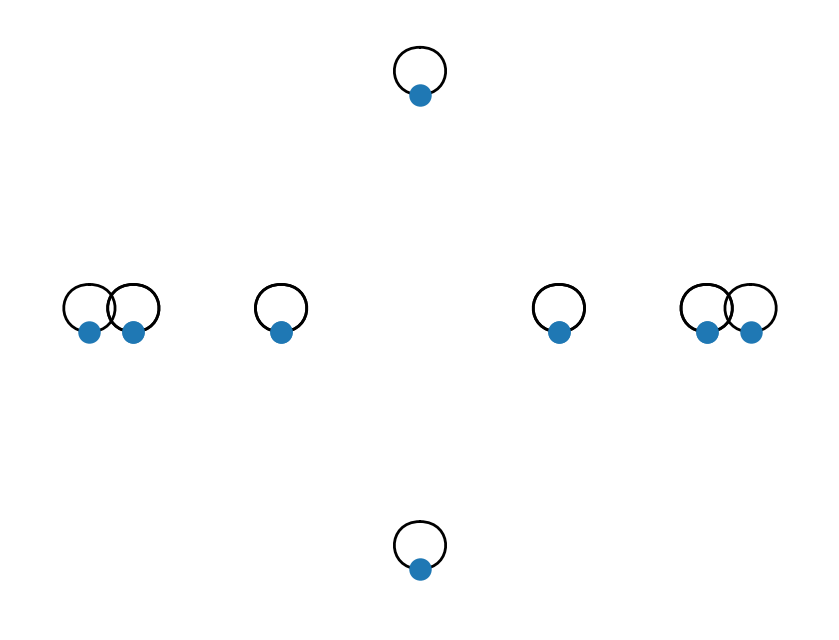

In [ ]:
nx_graph = dgl.to_networkx(graph)
plt.figure(figsize=(4, 3), dpi=200)
nx.draw(nx_graph, pos=nx.kamada_kawai_layout(nx_graph), node_size=50, arrows=False)
plt.show()

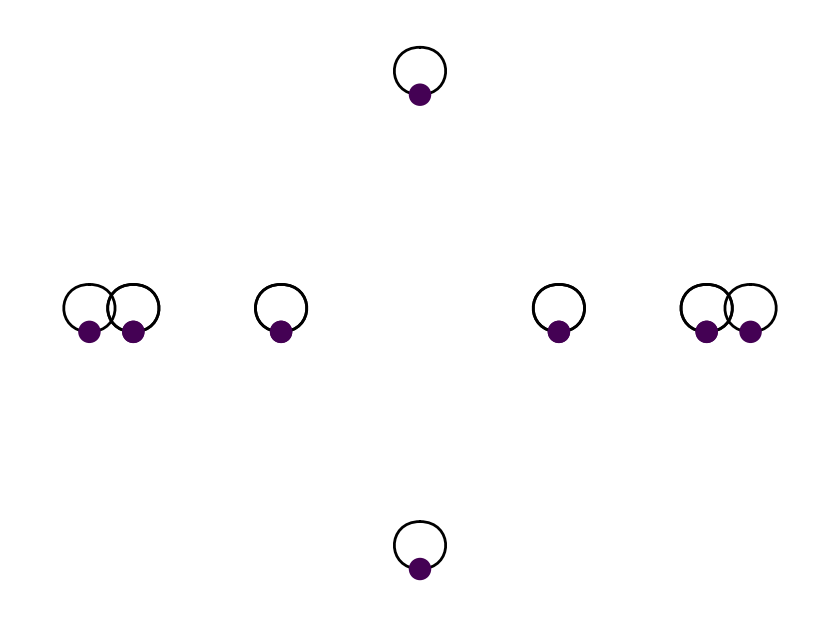

In [ ]:
nx_graph = dgl.to_networkx(graph, node_attrs=['b_factor'])
plt.figure(figsize=(4, 3), dpi=200)
nx.draw(nx_graph, pos=nx.kamada_kawai_layout(nx_graph), node_size=50, arrows=False,
        node_color=np.array([nx_graph.nodes[v]['b_factor'] for v in nx_graph]))
plt.show()